In [122]:
"""ライブラリ"""
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from statistics import mean, variance
from scipy import stats
from scipy.stats import norm
from collections import Counter
import copy

"""データ生成関数"""
def generate_data(directory, data_n, aged_data_n):
    data = []
    aged_data = []
    
    for i in range(1, data_n+1):
        tmp_data = pd.read_csv(directory+'/s'+str(i)+'.csv', header=None).values
        data.append(tmp_data)
    
    for i in range(1, aged_data_n+1):
        tmp_data = pd.read_csv(directory+'/s'+str(i)+'_aged.csv', header=None).values
        aged_data.append(tmp_data)
    
    data = np.array(data)
    aged_data = np.array(aged_data)
    
    return data, aged_data

newdata, ageddata = generate_data('fresh_aged_ieice', 50, 2)

"""0の数数える関数 二次元入れろ"""
def count_zero(data):
    
    tmp = []
    for i in range(data.shape[0]):
        a = (data[i].shape[0] * data[i].shape[1]) - np.count_nonzero(data[i])
        tmp.append(a)
        
    return tmp

"""一次元にする関数"""
def change_flatten(data):
    tmp = []
    for i in range(data.shape[0]):
        tmp.append(data[i].flatten())
        
    tmp = np.array(tmp)
    
    return tmp

"""0を消す関数 flatteしたやつ入れろ"""
def delete_zero(data):
    tmp = []
    for i in range(data.shape[0]):
        tmp2 = copy.deepcopy(data[i])
        tmp.append(tmp2[tmp2 != 0])
        
    tmp = np.array(tmp)
    
    return tmp

"""東西南北残差作り出す関数"""
def EWSN_residual(data):
    tmp_x = [0, 1, 0, -1]
    tmp_y = [-1, 0, 1, 0]

    residual_data = np.zeros_like(data)

    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                if data[i, j, k] != 0:
                    data_list = []
                    for l in range(4):
                        next_y = j + tmp_y[l]
                        next_x = k + tmp_x[l]
                        if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                            data_list.append(data[i, next_y, next_x])
    
                    data_mean = mean(data_list)
                    residual_data[i, j, k] = abs(data[i, j, k] - data_mean)

    return residual_data

"""king残差作り出す関数"""
def king_residual(data):
    tmp_x = [-1, 0, 1, 1, 1, 0, -1, -1]
    tmp_y = [-1, -1, -1, 0, 1, 1, 1, 0]
    
    residual_data = np.zeros_like(data)
    
    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                if data[i, j, k] != 0:
                    data_list = []
                    for l in range(8):
                        next_y = j + tmp_y[l]
                        next_x = k + tmp_x[l]
                        if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                            data_list.append(data[i, next_y, next_x])
    
                    data_mean = mean(data_list)
                    residual_data[i, j, k] = abs(data[i, j, k] - data_mean)

    return residual_data

"""確率密度関数の可視化"""
def plot_new(data):
    y = 11
    x = 5
    fig,ax = plt.subplots(y,x,figsize=(30,30))
    count = 0
    for i in range(y):
        for j in range(x):
            if count >= 52:
                break
            dummy = sns.distplot(data[count], ax=ax[i, j])
            count += 1
        if count >= 52:
            break
    
    plt.show()

"""リストを繋げる関数"""
def connect(a, b):
    tmp = []
    for i in range(a.shape[0]):
        tmp.append(a[i])
        
    for i in range(b.shape[0]):
        tmp.append(b[i])
    
    tmp = np.array(tmp)
    return tmp

"""QQプロット出力する関数"""
def qq(x):
    stats.probplot(x, dist="norm", plot=plt)  #QQプロット表示
    plt.pause(.01)

"""コルモゴロフスミルノフ検定する関数"""
def kolmogorov_smirnov(x):
    loc, scale = norm.fit(x)
    n = norm(loc=loc, scale=scale)  # create a normal distribution with loc and scale
    p = stats.kstest(x, n.cdf).pvalue  #コルモゴロフスミルノフ検定
    return p

"""シャピロウィルク検定する関数"""
def shapiro_wilk(x):
    p=stats.shapiro(x)[1]  #シャピロウィルク検定
    return p

"""合計値と平均出す関数 一次元混合データが望ましい"""
def summean_residual(data):
    tmpsum = []
    tmpmean = []
    for i in range(data.shape[0]):
        tmpsum.append(data[i].sum())
        tmpmean.append(mean(data[i]))
        
    tmpsum = np.array(tmpsum)
    tmpmean = np.array(tmpmean)
    
    return tmpsum, tmpmean

def ten(data):
    x = np.arange(1, 53)
    plt.scatter(x, data)
    plt.title("scatter")
    plt.xlabel("sample number")
    plt.ylabel("residual")
    plt.grid(True)
    plt.show()

def hoteling(data):
    # 標本平均
    mn = mean(data)
    
    # 標本分散
    vari = variance(data)
    
    # 異常度
    anomaly_scores = []
    for x in data:
        anomaly_score = (x - mn)**2 / vari
        anomaly_scores.append(anomaly_score)
    
    # カイ二乗分布による5%水準の閾値
    threshold = stats.chi2.interval(0.95, 1)[1]
    
    # 結果の描画
    num = np.arange(1, 53)
    plt.plot(num, anomaly_scores, "o", color = "b")
    plt.plot([0,53],[threshold, threshold], 'k-', color = "r", ls = "dashed")
    plt.xlabel("Sample number")
    plt.ylabel("Anomaly score")
    plt.show()
    
    for i, j in enumerate(anomaly_scores):
        if j >= threshold:
            print(f'異常index：{i+1}')

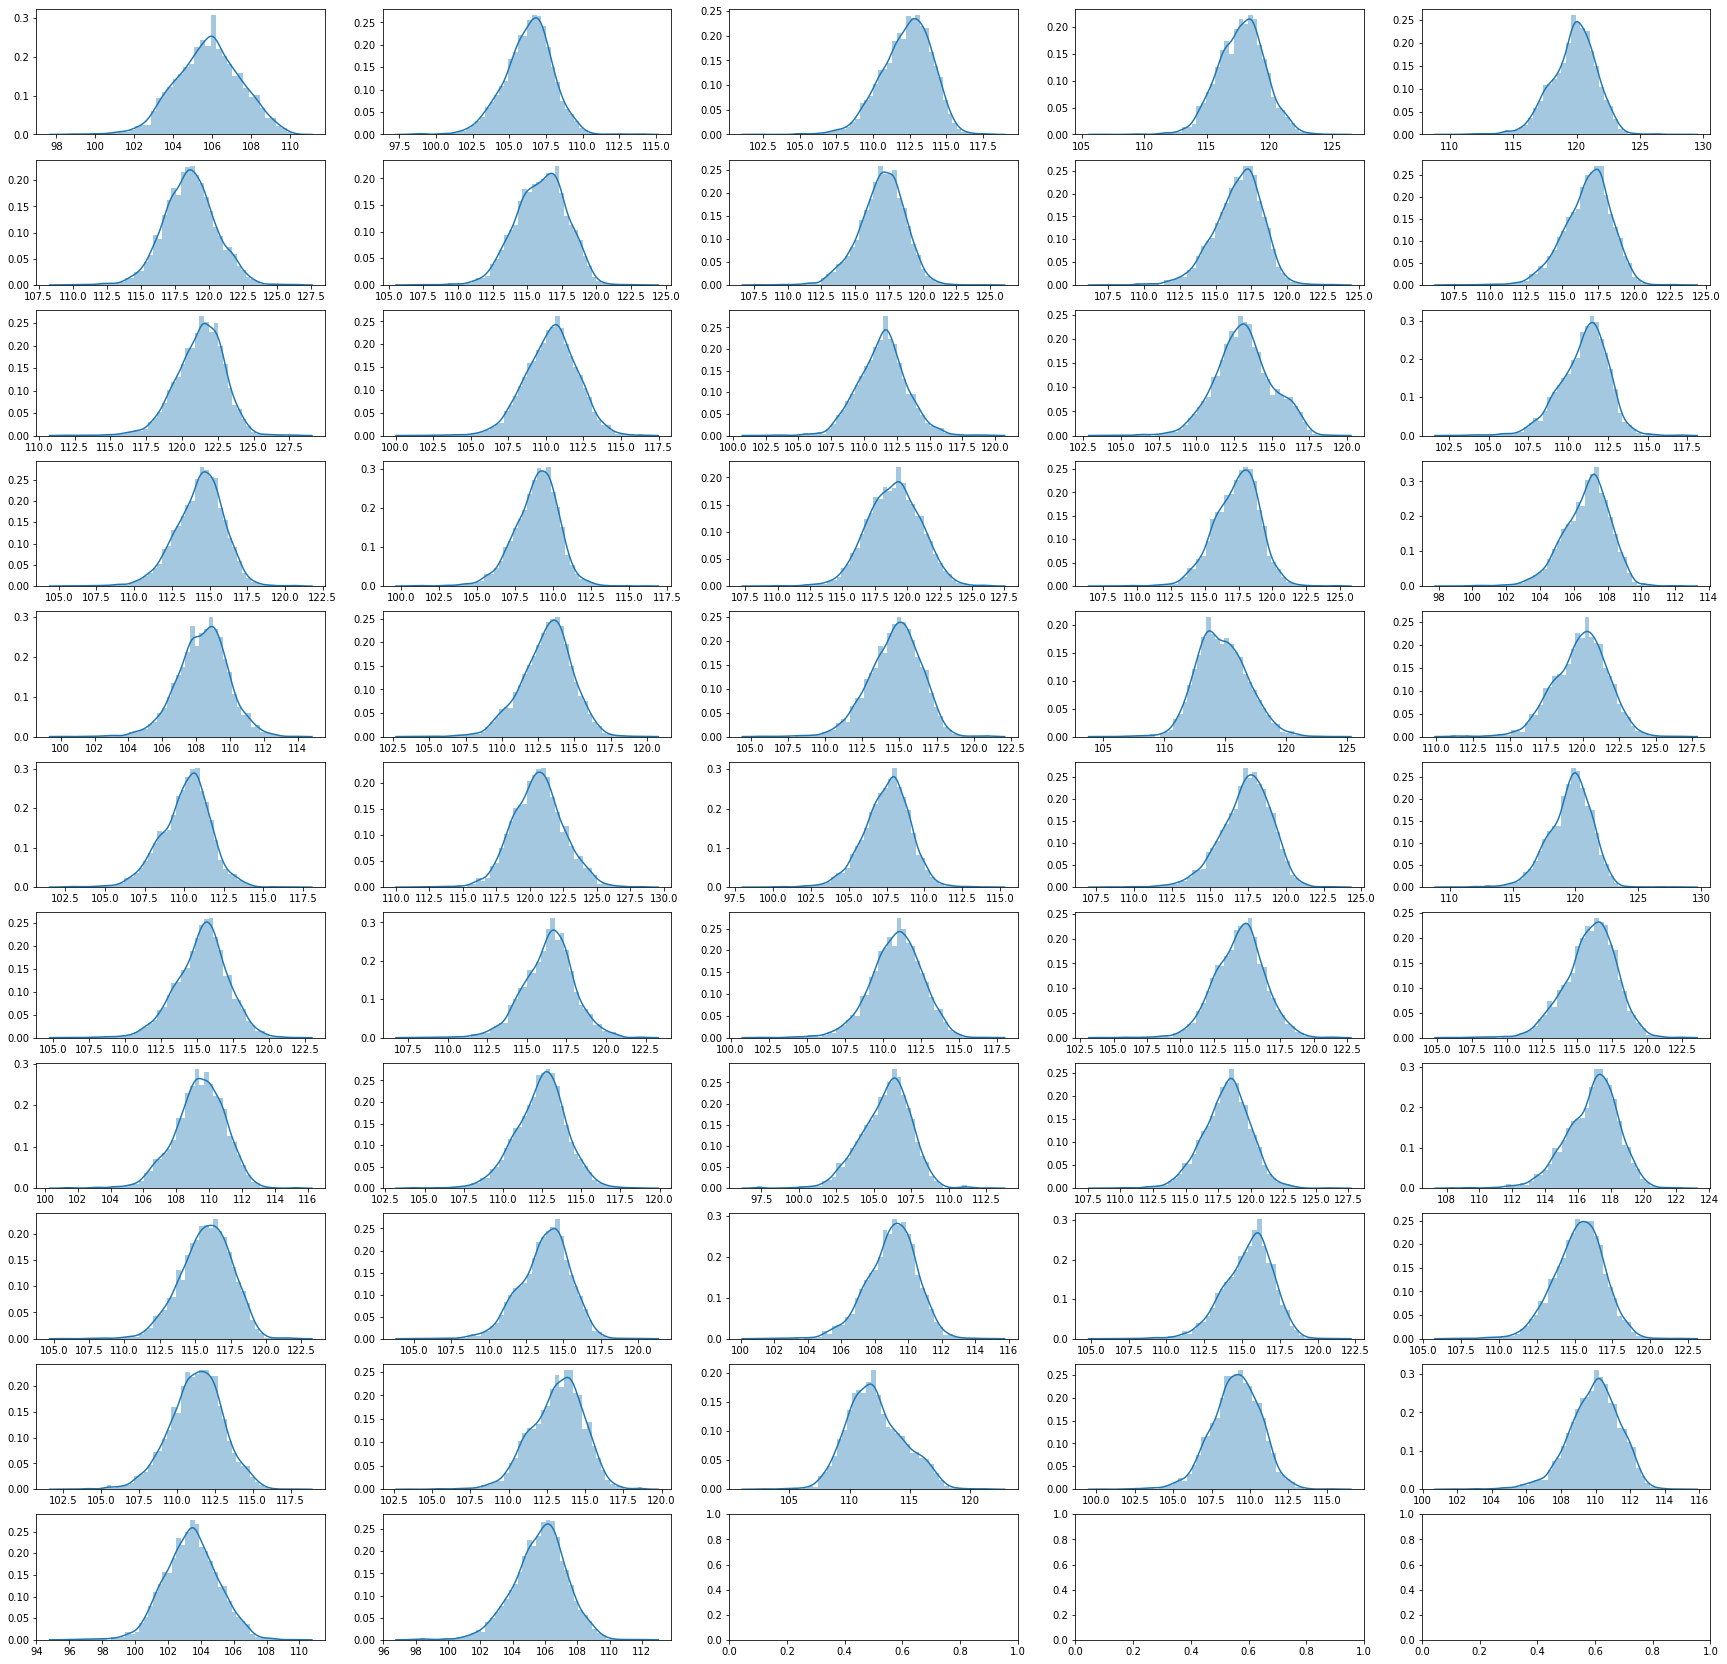

In [142]:
data = delete_zero(change_flatten(connect(newdata, ageddata)))
plot_new(data)

QQプロット


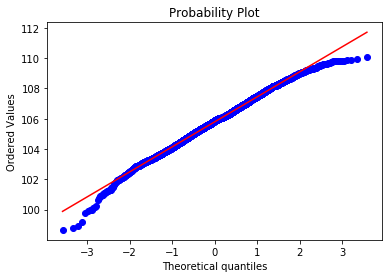

コルモゴロフスミルノフ検定:0.17664074847314698
シャピロウィルク検定：4.284796961684378e-09

QQプロット


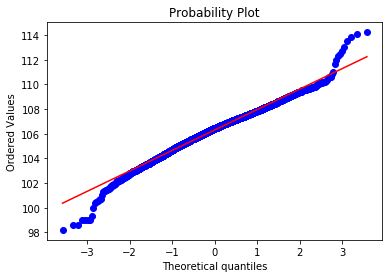

コルモゴロフスミルノフ検定:7.78987420010969e-05
シャピロウィルク検定：7.951204361789677e-19

QQプロット


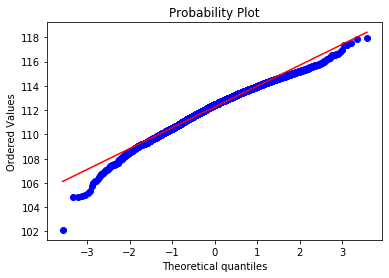

コルモゴロフスミルノフ検定:9.001053222443759e-07
シャピロウィルク検定：4.22764030075411e-20

QQプロット


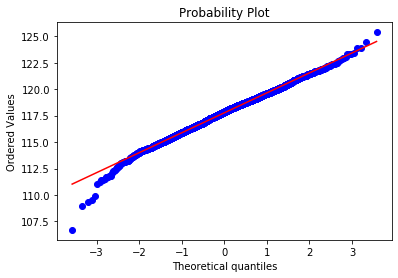

コルモゴロフスミルノフ検定:0.014580104332488901
シャピロウィルク検定：3.0700930686577976e-10

QQプロット


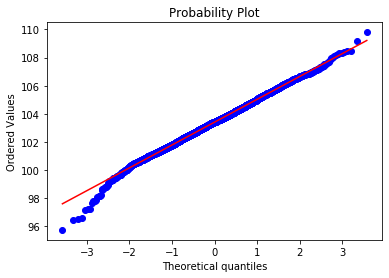

コルモゴロフスミルノフ検定:0.5106773984202955
シャピロウィルク検定：5.368177085074421e-07]

QQプロット


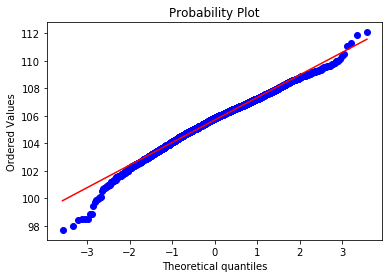

コルモゴロフスミルノフ検定:0.00011019906680708529
シャピロウィルク検定：1.6100105799878202e-16]



In [46]:
for i in range(4):
    print('QQプロット')
    qq(data[i])
    tmp = kolmogorov_smirnov(data[i])
    print(f'コルモゴロフスミルノフ検定:{tmp}')
    tmp = shapiro_wilk(data[i])
    print(f'シャピロウィルク検定：{tmp}')
    print()
    
for i in range(50, 52):
    print('QQプロット')
    qq(data[i])
    tmp = kolmogorov_smirnov(data[i])
    print(f'コルモゴロフスミルノフ検定:{tmp}')
    tmp = shapiro_wilk(data[i])
    print(f'シャピロウィルク検定：{tmp}]')
    print()


In [54]:
counter = 0
counter2 = 0
for i in range(52):
    a = kolmogorov_smirnov(data[i])
    b = shapiro_wilk(data[i])
    
    if a > 0.05:
        counter += 1
    if b > 0.05:
        counter2 += 1
        
print(f'コルモゴロフスミルノフ検定:{counter}')
print(f'シャピロウィルク検定:{counter2}')

コルモゴロフスミルノフ検定:5
シャピロウィルク検定:0


In [55]:
a, b = generate_data('fresh_aged_ieice', 50, 2)

In [56]:
ab = connect(a, b)

In [57]:
print(count_zero(ab))

[920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 915, 915]


In [58]:
resi = EWSN_residual(ab)
resi2 = king_residual(ab)

In [68]:
resi_sum, resi_mean = summean_residual(delete_zero(change_flatten(resi)))
resi_sum2, resi_mean2 = summean_residual(delete_zero(change_flatten(resi2)))

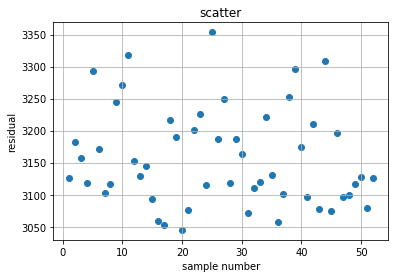

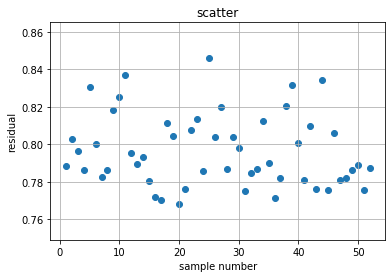

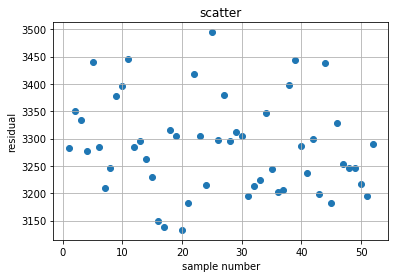

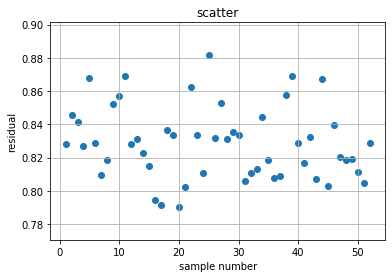

In [69]:
ten(resi_sum)
ten(resi_mean)
ten(resi_sum2)
ten(resi_mean2)

In [99]:
a = delete_zero(change_flatten(resi))
b = delete_zero(change_flatten(resi2))

anomaly_scores1 = []
anomaly_scores2 = []

for x in a:
    mn = mean(x)
    vari = variance(x)
    
    tmp = 0
    for i in x:
        anomaly_score = ((i - mn) / vari)**2
        tmp += anomaly_score
    
    anomaly_scores1.append(tmp)
    
for x in b:
    mn = mean(x)
    vari = variance(x)
    
    tmp = 0
    for i in x:
        anomaly_score = ((i - mn) / vari)**2
        tmp += anomaly_score
    
    anomaly_scores2.append(tmp)

In [100]:
for i in a:
    print(i.shape)
print('------------')
for i in b:
    print(i.shape)


(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3963,)
(3964,)
(3962,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3963,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3969,)
(3969,)
------------
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3964,)
(3969,)
(3969,)


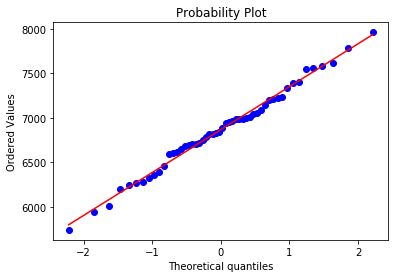

0.979923153249658
0.9769276976585388


In [101]:
qq(anomaly_scores1)
a = kolmogorov_smirnov(anomaly_scores1)
b = shapiro_wilk(anomaly_scores1)
print(a)
print(b)

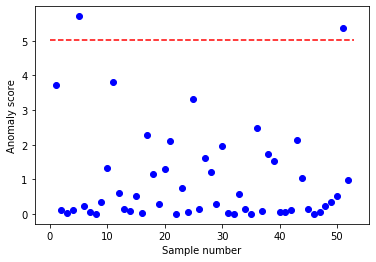

異常index：5
異常index：51


In [112]:
# 標本平均
mn = mean(anomaly_scores1)

# 標本分散
vari = variance(anomaly_scores1)

# 異常度
anomaly_scores = []
for x in anomaly_scores1:
    anomaly_score = (x - mn)**2 / vari
    anomaly_scores.append(anomaly_score)

# カイ二乗分布による5%水準の閾値
threshold = stats.chi2.interval(0.95, 1)[1]

# 結果の描画
num = np.arange(1, 53)
plt.plot(num, anomaly_scores, "o", color = "b")
plt.plot([0,53],[threshold, threshold], 'k-', color = "r", ls = "dashed")
plt.xlabel("Sample number")
plt.ylabel("Anomaly score")
plt.show()

for i, j in enumerate(anomaly_scores):
    if j >= threshold:
        print(f'異常index：{i+1}')

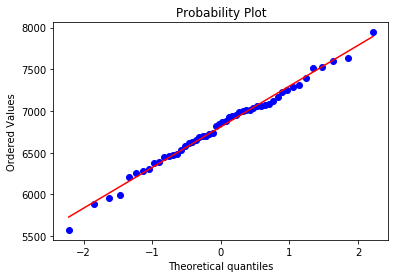

0.9849633899119943
0.9935181736946106


In [102]:
qq(anomaly_scores2)
a = kolmogorov_smirnov(anomaly_scores2)
b = shapiro_wilk(anomaly_scores2)
print(a)
print(b)

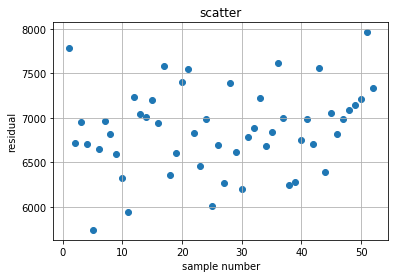

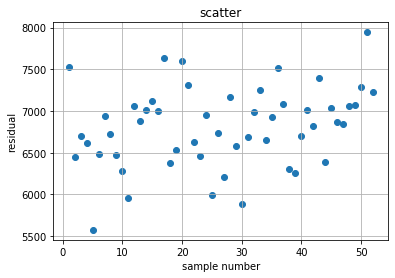

In [105]:
ten(anomaly_scores1)
ten(anomaly_scores2)

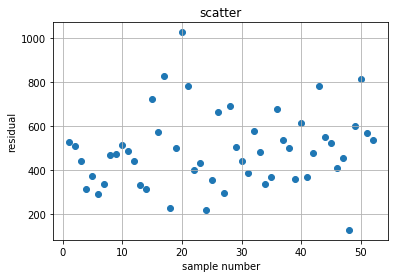

In [106]:
check = delete_zero(ab)
check_list = []

for x in check:
    mn = mean(x)
    vari = variance(x)
    
    tmp = 0
    for i in range(3964):
        anomaly_score = ((x[i] - mn)/vari)**2 / vari
        tmp += anomaly_score
    
    check_list.append(tmp)
    
ten(check_list)

In [107]:
check.shape
for x in check:
    print(x.shape)
    print(mean(x))
    print(variance(x))

(3964,)
105.79661190716448
2.74045128974968
(3964,)
106.31207320887992
2.793433366473576
(3964,)
112.26840701311806
3.0011727091155778
(3964,)
117.76759566094854
3.5699628621007737
(3964,)
119.78303660443996
3.2754259731059037
(3964,)
118.58450428859737
3.7045546793457214
(3964,)
116.01611228557013
3.4280741817036824
(3964,)
116.99541569122098
2.9056138434579877
(3964,)
116.57618985872855
2.904850508915549
(3964,)
116.76456309283552
2.7818972186299478
(3964,)
121.2529077951564
2.8612037106154755
(3964,)
110.35864962159435
3.00222544447374
(3964,)
111.38941309283553
3.4513570204265664
(3964,)
113.15057898587285
3.5657682597576392
(3964,)
110.99669235620586
2.3462850246526354
(3964,)
114.34012333501514
2.6281974524076483
(3964,)
108.90290401109989
2.18678599438966
(3964,)
118.97670032795156
4.192074311458383
(3964,)
117.36748224016145
2.821856361163186
(3964,)
106.7588776740666
1.9653989449442733
(3964,)
108.38964016145307
2.2551140399965424
(3964,)
113.09059485368314
3.1448702150429
(39

In [115]:
import numpy as np
import treelib

class IsolateTree:

    class __data:
        def __init__(self):
            self.feature_split = None
            self.threshold_split = None
            self.n_samples = None

    def __init__(self):
        self.__tree = treelib.Tree() #treelibライブラリ 木を作った

    def __get_normalization_factor(self, n): 
        return 2 * (np.log(n-1) + 0.5772156649) - 2 * (n-1) / n

    def __create_tree(self, parent, X):
        n_samples, n_features = X.shape

        data = self.__data() #コンストラクタ起動，三つのデータを持つ構造を作った

        if n_samples == 0: #調べるサンプルが無くなったら？
            data.n_samples = n_samples
            self.__tree.update_node(parent.identifier, data=data) #何かしらアップデータ
            return

        if self.__tree.depth() > self.__max_height or (X == X[0]).all(): #深さが最大を超えたか...
            data.n_samples = n_samples
            self.__tree.update_node(parent.identifier, data=data) #何かしらアップデータ
            return

        data.feature_split = np.random.choice(n_features, 1)
        data.threshold_split = (max(X[:, data.feature_split]) - min(X[:, data.feature_split])) * np.random.rand() + min(X[:, data.feature_split])

        self.__tree.update_node(parent.identifier, data=data)

        less_items = np.flatnonzero(X[:, data.feature_split] < data.threshold_split)
        greater_items = np.flatnonzero(X[:, data.feature_split] >= data.threshold_split)

        node = self.__tree.create_node('less ' + str(data.threshold_split), parent=parent)
        self.__create_tree(node, X[less_items])
        
        node = self.__tree.create_node('greater ' + str(data.threshold_split), parent=parent)
        self.__create_tree(node, X[greater_items])


    #他の関数に私たりする変数は__アンダースコア付けてない
    def fit(self, X):
        n_samples = X.shape[0]

        self.__c = self.__get_normalization_factor(n_samples) #正規化？

        self.__max_height = np.round(np.log2(n_samples)) #二部探索したときの最大の深さを事前に知っておく

        root = self.__tree.create_node('root') #treelibライブラリ rootノードを作った
        self.__create_tree(root, X)

    def __get_path_length(self, x, node):
        if node.is_leaf():
            return self.__tree.depth(node.identifier) + (self.__get_normalization_factor(node.data.n_samples) if node.data.n_samples > 1 else 0)

        for child in self.__tree.children(node.identifier):
            if x[node.data.feature_split] < node.data.threshold_split and child.tag == 'less ' + str(node.data.threshold_split):
                return self.__get_path_length(x, child)
            elif x[node.data.feature_split] >= node.data.threshold_split and child.tag == 'greater ' + str(node.data.threshold_split):
                return self.__get_path_length(x, child)

    def get_abnormal_score(self, X):
        return 2 ** (-np.apply_along_axis(self.__get_path_length, 1, X, self.__tree.get_node(self.__tree.root)) / self.__c)


class IsolateForest:
    def __init__(self):
        self.__trees = []

    def fit(self, X, n_trees, n_subsamples):

        n_samples = X.shape[0]

        for _ in range(n_trees):
            sub_items = np.random.choice(n_samples, n_subsamples, replace=False)

            tree = IsolateTree()
            tree.fit(X[sub_items])

            self.__trees.append(tree)

    def predict(self,X):
        n_samples = X.shape[0]

        abnormal_scores = np.zeros((n_samples, len(self.__trees)))
        for i in range(len(self.__trees)):
            abnormal_scores[:, i] = self.__trees[i].get_abnormal_score(X)

        return np.mean(abnormal_scores, axis=1)


In [118]:
a, b = generate_data('fresh_aged_ieice', 50, 2)
ab = connect(a, b)
print(count_zero(ab))
resi = EWSN_residual(ab)
resi2 = king_residual(ab)
a = delete_zero(change_flatten(resi))
b = delete_zero(change_flatten(resi2))

tr = IsolateForest()

[912, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 915, 915]


IndexError: too many indices for array

In [119]:
a, b = generate_data('fresh_aged_ieice', 50, 2)

In [120]:
ab = connect(a, b)
print(count_zero(ab))

[912, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 920, 915, 915]


In [121]:
ab

array([array([[109.2887, 107.9591, 109.6835, ..., 108.1733, 106.9519, 106.9519],
       [107.8388, 108.8326, 108.9452, ..., 106.05  , 108.2462, 107.3608],
       [108.3084, 108.6385, 108.2023, ..., 105.7663, 108.137 , 108.0538],
       ...,
       [107.2766, 108.2539, 108.1527, ...,   0.    ,   0.    ,   0.    ],
       [107.9099, 108.7821, 108.7378, ...,   0.    ,   0.    ,   0.    ],
       [104.0332, 107.4869, 107.8312, ...,   0.    ,   0.    ,   0.    ]]),
       array([[108.6884, 106.7148, 109.7774, ..., 112.5092, 112.7148, 111.9461],
       [107.5174, 108.7945, 108.3819, ..., 110.1793, 109.8019, 108.1984],
       [108.2164, 107.7119, 108.8572, ..., 106.4006, 108.2149, 107.8256],
       ...,
       [109.8266, 110.152 , 111.016 , ...,   0.    ,   0.    ,   0.    ],
       [110.1722, 109.4173, 109.7473, ...,   0.    ,   0.    ,   0.    ],
       [106.818 , 109.4205, 110.8175, ...,   0.    ,   0.    ,   0.    ]]),
       array([[116.6074, 113.7457, 116.7763, ..., 117.917 , 117.3741, 